In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while (data := f.read(1048576)):
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))


print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
print(DATA_HUB)
print(type(DATA_HUB))

{'kaggle_house_train': ('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv', '585e9cc93e70b39160e7921475f9bcd7d31219ce'), 'kaggle_house_test': ('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')}
<class 'dict'>


In [6]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)


In [10]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and  # `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
print(all_features)

      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
1      -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
2       0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
3       0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   
4       0.067320     0.629439  0.518814     1.355319    -0.507197   0.947040   
...          ...          ...       ...          ...          ...        ...   
1454    2.419286    -2.069222 -1.043758    -1.481667     1.289537  -0.043338   
1455    2.419286    -2.069222 -1.049083    -1.481667    -0.507197  -0.043338   
1456   -0.873466     3.884968  1.246594    -0.772420     1.289537  -0.373465   
1457    0.655311    -0.312950  0.034599    -0.772420    -0.507197   0.682939   
1458    0.067320     0.201080 -0.068608     0.646073    -0.507197   0.715952   

      YearRemodAdd  MasVnrArea  BsmtFin

In [11]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [12]:
loss=nn.MSELoss()
in_features=train_features.shape[1]

def get_net():
    net=nn.Sequential(nn.Linear(in_features,1))
    return net

In [13]:
def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [14]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l=loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [15]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid

In [16]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',legend=['train','valid'],yscale='log')
        print(f'fold {i+1},train log rmse {float(train_ls[-1]):f},valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum/k,valid_l_sum/k

fold 1,train log rmse 0.170453,valid log rmse 0.156317
fold 2,train log rmse 0.162604,valid log rmse 0.191142
fold 3,train log rmse 0.163816,valid log rmse 0.168147
fold 4,train log rmse 0.168516,valid log rmse 0.154807
fold 5,train log rmse 0.163127,valid log rmse 0.182624
5-fold validation: avg train log rmse: 0.165703, avg valid log rmse: 0.170607


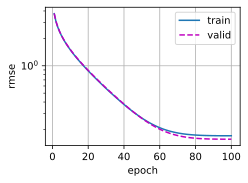

In [17]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, avg valid log rmse: {float(valid_l):f}')

In [18]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net=get_net()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',ylabel='rmse',yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.csv',index=False)

train log rmse 0.162474


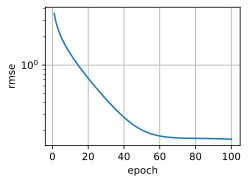

In [19]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)